In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import os
import networkx as nx

In [2]:
#Read discussion network data from a csv file
dnet_df = pd.read_csv('issues_network_with_affiliations.csv')
#Display the first 5 rows of the dataframe
dnet_df.head()

,consumer,contributor,consumption,contributor_affiliation,consumer_affiliation
0,kondoh2,syohex,1,Computing Platforms Federated Labratory,Computing Platforms Federated Labratory
1,kondoh2,syouji,1,Computing Platforms Federated Labratory,Computing Platforms Federated Labratory
2,kondoh2,yk-fujii,1,tier4,Computing Platforms Federated Labratory
3,kondoh2,shinpei0208,1,tier4,Computing Platforms Federated Labratory
4,syohex,syouji,1,Computing Platforms Federated Labratory,Computing Platforms Federated Labratory


In [3]:
dnet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   consumer                 534 non-null    object
 1   contributor              534 non-null    object
 2   consumption              534 non-null    int64 
 3   contributor_affiliation  492 non-null    object
 4   consumer_affiliation     430 non-null    object
dtypes: int64(1), object(4)
memory usage: 21.0+ KB


In [4]:
#Aggregate the data by contributor_affiliation and consumer_affiliation, sum teh values of consumption, keep the contributor_affiliation and consumer_affiliation columns
dnet_grouped = dnet_df.groupby(['contributor_affiliation', 'consumer_affiliation'])['consumption'].sum().reset_index()
#Display the first 5 rows of the dataframe
dnet_grouped.head()

,contributor_affiliation,consumer_affiliation,consumption
0,42 Wolfsburg,macnica,1
1,@xiaopeng,Nagoya University,1
2,@xiaopeng,map4,2
3,@xiaopeng,tier4,3
4,Aisan Tech,@GITAI,1


In [5]:
#describe the dataframe
dnet_grouped.describe()

,consumption
count,131.000000
mean,3.038168
std,9.199000
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,101.000000


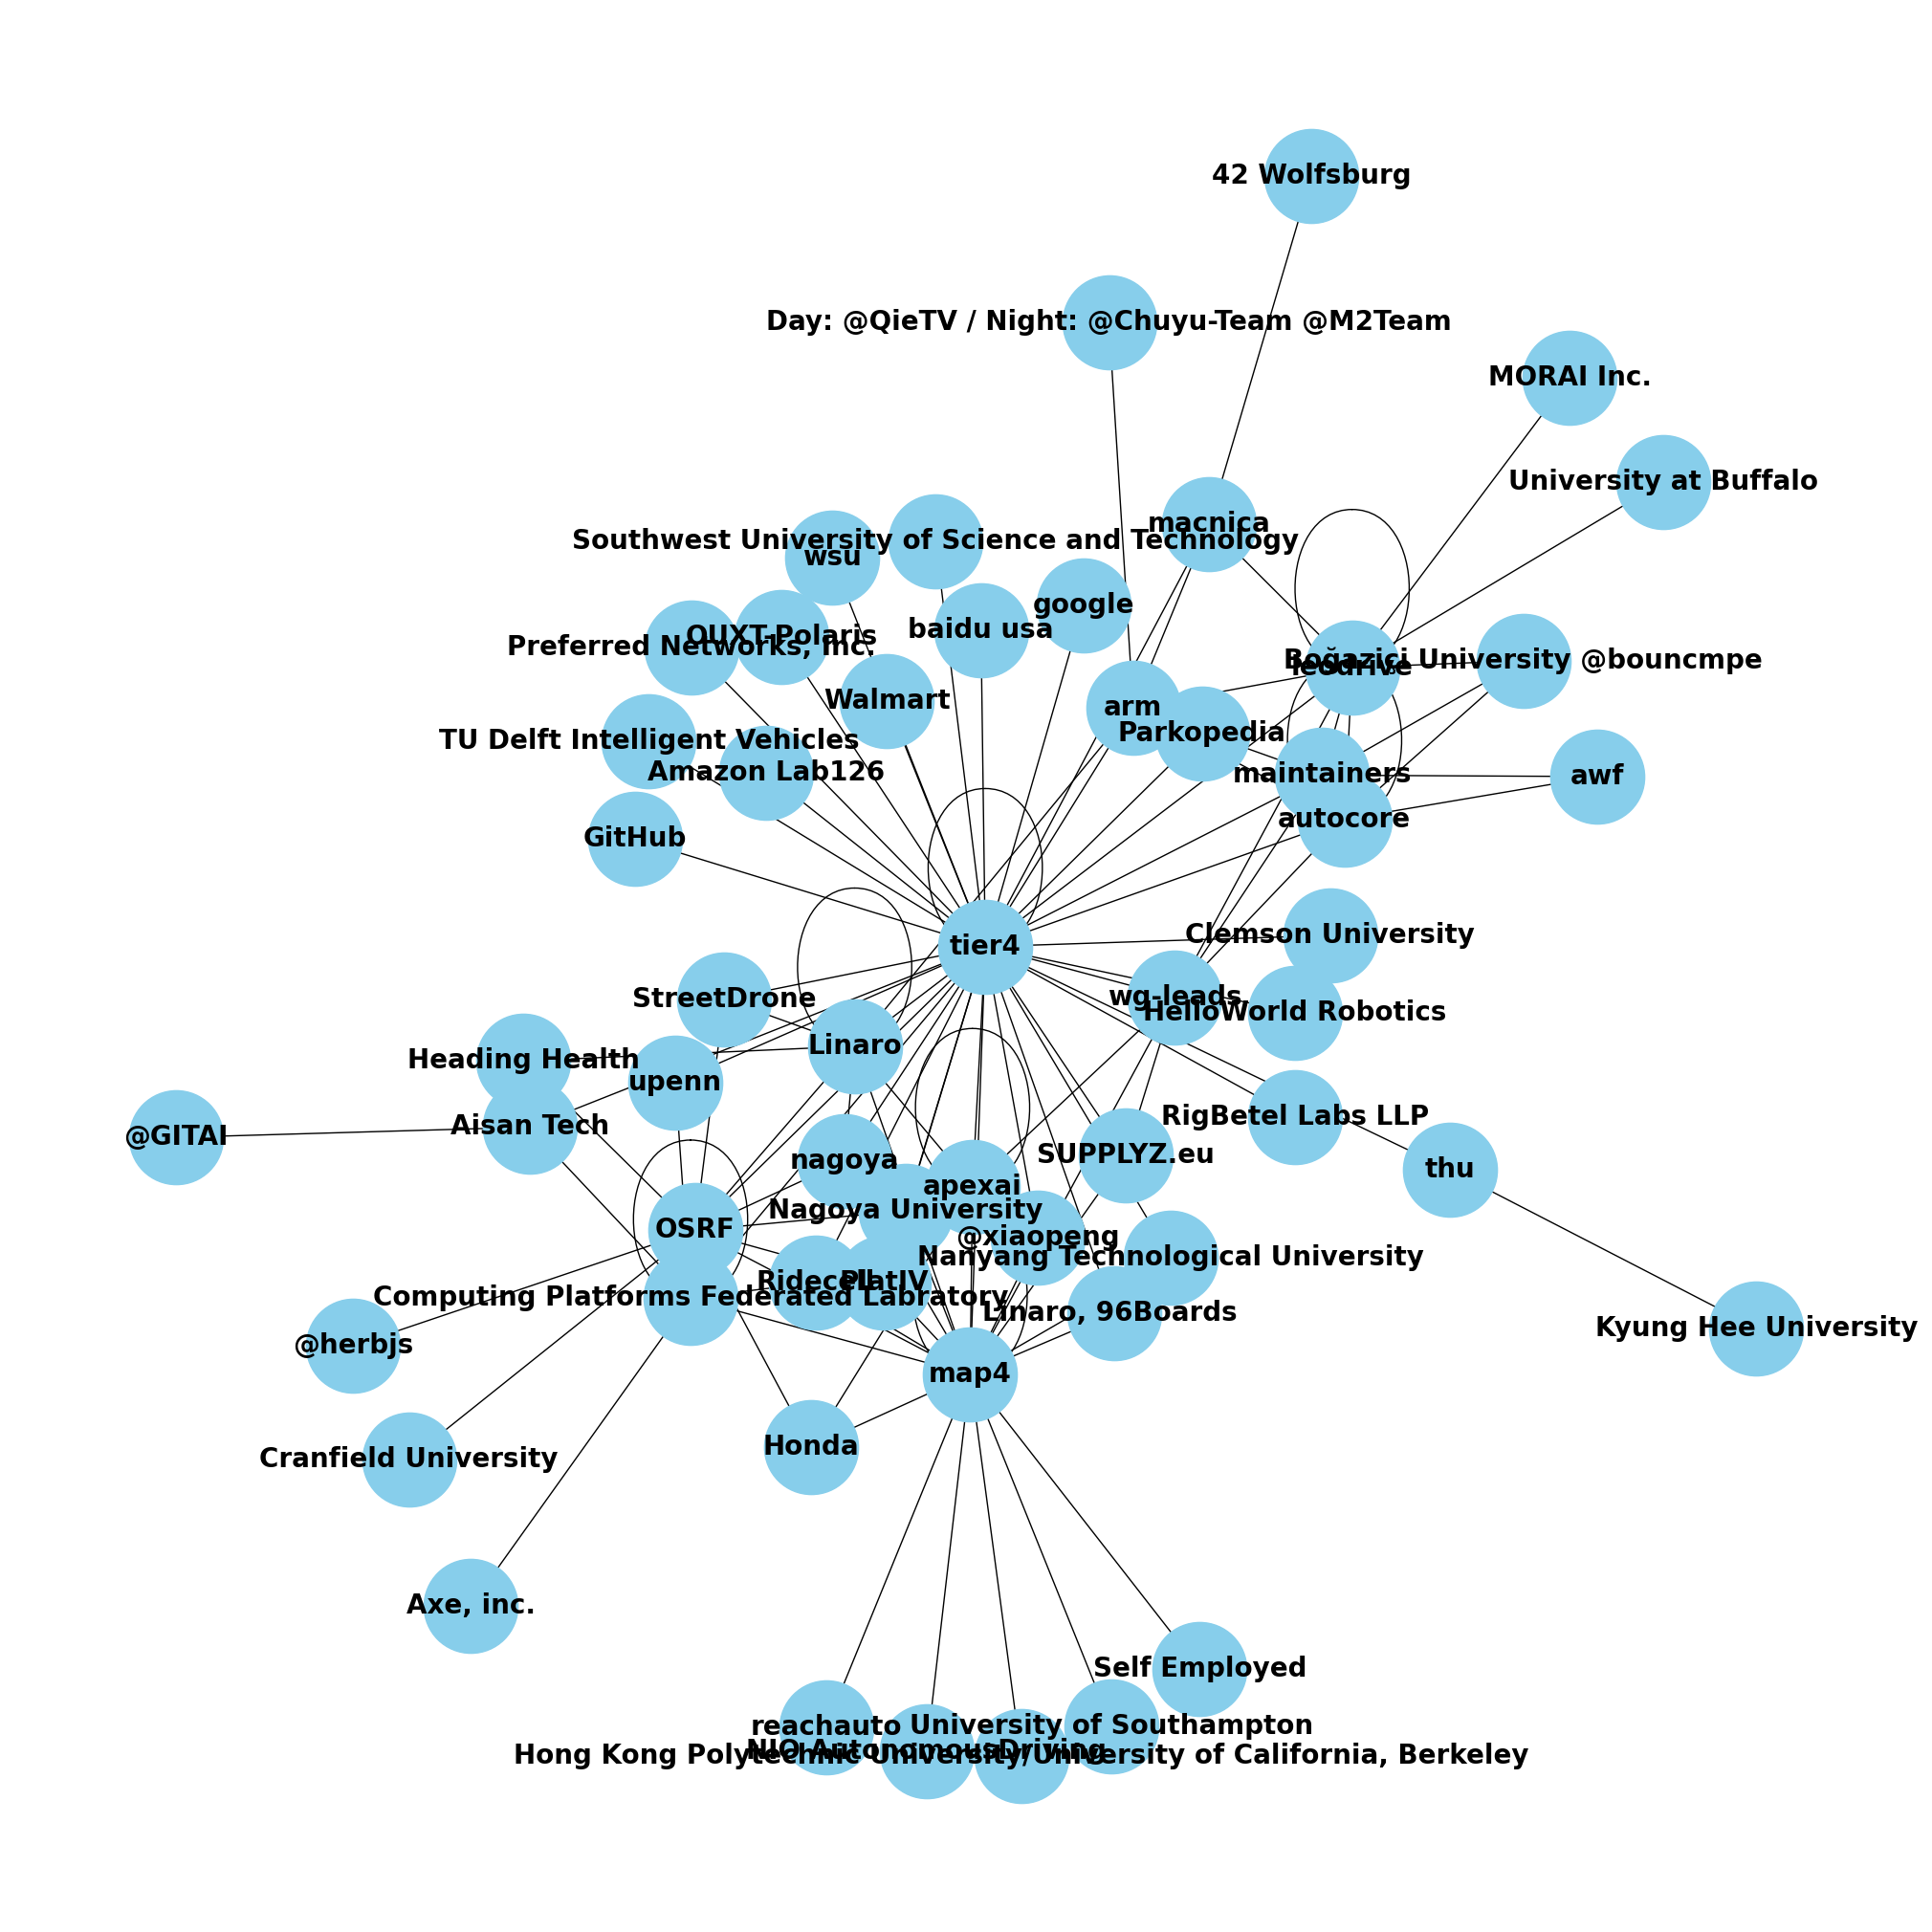

In [6]:
#Draw a network among the affiliations based on the consumption of the discussions
G = nx.from_pandas_edgelist(dnet_grouped, 'contributor_affiliation', 'consumer_affiliation', 'consumption')
plt.figure(figsize=(20, 20))
nx.draw(G, with_labels=True, node_size=5000, node_color='skyblue', font_size=20, font_weight='bold')
plt.show()

In [7]:
# #Right now, the network is assymetric, i.e., we have separate records for consumption from a to b and from b to a. We need to make it symmetric
# #Create a copy of the dataframe
# dnet_grouped_copy = dnet_grouped.copy()
# #Rename the columns
# dnet_grouped_copy.columns = ['consumer_affiliation', 'contributor_affiliation', 'consumption']
# #Append the two dataframes
# dnet_grouped_symmetric = dnet_grouped.append(dnet_grouped_copy)
# #Group the data by contributor_affiliation and consumer_affiliation, sum the values of consumption
# dnet_grouped_symmetric = dnet_grouped_symmetric.groupby(['contributor_affiliation', 'consumer_affiliation'])['consumption'].sum().reset_index()
# #Display the first 5 rows of the dataframe

In [8]:
!pip install pyvis

In [9]:
# Sort the DataFrame based on the "consumption" column from highest to lowest values
dnet_grouped_sorted = dnet_grouped.sort_values(by='consumption', ascending=False)

# Display the sorted DataFrame
print(dnet_grouped_sorted)

    contributor_affiliation consumer_affiliation  consumption
123                   tier4                tier4          101
92                     map4                tier4           22
41                     OSRF                tier4           18
120                   tier4                 map4           14
59                   apexai                tier4           12
..                      ...                  ...          ...
68                      awf             autocore            1
67                 autocore                tier4            1
66                 autocore          maintainers            1
1                 @xiaopeng    Nagoya University            1
0              42 Wolfsburg              macnica            1

[131 rows x 3 columns]


In [10]:
import pandas as pd
from pyvis.network import Network

# Read discussion network data from a csv file
dnet_df = pd.read_csv('issues_network_with_affiliations.csv')

# Aggregate the data by contributor_affiliation and consumer_affiliation, sum the values of consumption
dnet_grouped = dnet_df.groupby(['contributor_affiliation', 'consumer_affiliation'])['consumption'].sum().reset_index()

# Sort the DataFrame by consumption (highest to lowest)
dnet_grouped_sorted = dnet_grouped.sort_values(by='consumption', ascending=False)

# Create a pyvis network with a white background
net = Network(height="750px", width="100%", bgcolor="white", font_color="black", directed=True)

# Create an empty dictionary to store added nodes
added_nodes = {}

# Define the minimum weight threshold for displaying edges
min_weight_threshold = 0

# Create a dictionary to store the count of rows for each pair of interchangeable affiliations
interchangeable_counts = {}

# Count the occurrences of each pair of interchangeable affiliations
for _, row in dnet_grouped.iterrows():
    contributor_affiliation = row['contributor_affiliation']
    consumer_affiliation = row['consumer_affiliation']
    if contributor_affiliation > consumer_affiliation:
        pair = (consumer_affiliation, contributor_affiliation)
    else:
        pair = (contributor_affiliation, consumer_affiliation)
    interchangeable_counts[pair] = interchangeable_counts.get(pair, 0) + 1

# Add nodes for each unique affiliation (handling potential missing values)
for affiliation in pd.concat([dnet_grouped_sorted['contributor_affiliation'], dnet_grouped_sorted['consumer_affiliation']]).unique():
    if not pd.isna(affiliation):
        net.add_node(affiliation, label=affiliation, size=20, color='lightblue')
        added_nodes[affiliation] = True

# Add edges to the network with the aggregated consumption values and adjusted width
for index, row in dnet_grouped_sorted.iterrows():
    contributor_affiliation = row['contributor_affiliation']
    consumer_affiliation = row['consumer_affiliation']
    consumption = row['consumption']

    # Add edge only if contributor and consumer affiliations are not NaN and weight meets threshold
    if not pd.isna(consumer_affiliation) and not pd.isna(contributor_affiliation) and consumption >= min_weight_threshold:
        # Ensure we add edges in both directions for interchangeable affiliations
        edge_key = (contributor_affiliation, consumer_affiliation)
        if interchangeable_counts.get(edge_key, 0) > 1:
            # Add edge between affiliations in both directions if not added already
            if edge_key not in added_nodes:
                net.add_edge(contributor_affiliation, consumer_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[edge_key] = True
            if (consumer_affiliation, contributor_affiliation) not in added_nodes:
                net.add_edge(consumer_affiliation, contributor_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[(consumer_affiliation, contributor_affiliation)] = True
        else:
            # Add only one edge if the affiliations are not interchangeable or there's only one occurrence
            if edge_key not in added_nodes:
                net.add_edge(contributor_affiliation, consumer_affiliation, weight=consumption, color='black', width=min(10, consumption * 0.2))
                added_nodes[edge_key] = True

# Set the layout algorithm to force-directed
net.barnes_hut(gravity=-8000, central_gravity=0.3, spring_length=200)

# Save the network to an HTML file
net.save_graph("issues_network_directed_2.html")